<div id="toc"></div>

# Objetivo

Implementação de uma rede neural de duas camadas com capacidade para a resolução de problemas não-lineares e estudar os efeitos da regularização sobre o desempenho do modelo.

# Execução

## Definição de Extreme Learning Machines (ELM)

$$
X_{(N, n)} \xrightarrow{Z_{n, p}} H_{(n, p)} \xrightarrow{w_{(p, 1)}} y_{(N, 1)}
$$


## Bibliotecas relevantes para o código

In [99]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Geração de dados sintéticos

In [100]:
std_dev = 1.2
n_samples = 50

* `std_dev`: variância da distribuição dos dados do problema de separação não linear
* `n_samples`: número de observações para cada grupo de observações gerado aleatoriamente

### Geração de classes para problemas de separação não-lineares

In [ ]:
class_0 = np.vstack([
    (
        np.random.normal(size=(n_samples, 2), scale=std_dev)
        + np.tile([2, 2], n_samples).reshape(-1, 2)
    ),
    (
        np.random.normal(size=(n_samples, 2), scale=std_dev)
        - np.tile([2, 2], n_samples).reshape(-1, 2)
    )
])

class_1 = np.vstack([
    (
        np.random.normal(size=(n_samples, 2), scale=std_dev)
        + np.tile([2, -2], n_samples).reshape(-1, 2)
    ),
    (
        np.random.normal(size=(n_samples, 2), scale=std_dev)
        + np.tile([-2, 2], n_samples).reshape(-1, 2)
    )
])

data = np.vstack([class_0, class_1])
target = np.repeat([-1, 1], repeats=n_samples * 2).reshape(-1, 1)
data.shape, target.shape

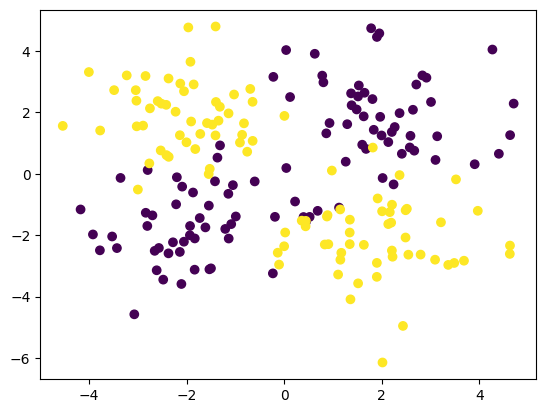

In [ ]:
plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

## Exercício ELM Clássica

**Especificação de parâmetros**

In [ ]:
neurons_hidden = 10
neurons_output = 1

**Camada de Entrada:** geração de pesos aleatórios

In [ ]:
input_weights = np.random.uniform(size=(data.shape[1] + 1, neurons_hidden))
input_weights.shape

(3, 10)

**Camada Escondida:** transformação da entrada com função de ativação não linear

In [ ]:
hidden_input = (
    np.hstack([np.ones(shape=(data.shape[0], 1)), data])
    @ input_weights
)
hidden_input.shape

(200, 10)

In [ ]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([np.ones(shape=(data.shape[0], 1)), hidden_output])
hidden_output.shape

(200, 11)

**Camada de Saída:** cálculo de pesos da camada de saída

In [ ]:
output_weights = np.linalg.pinv(hidden_output) @ target
output_weights.shape

(11, 1)

**Camada de Saída:** cálculo dos valores de saída da rede

In [ ]:
output_input = hidden_output @ output_weights
output_input.shape

(200, 1)

In [ ]:
output_output = output_input * 1

**Avaliação de resultados da classificação**

In [ ]:
print(classification_report(y_pred=output_output > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.85      0.84      0.84       100
        True       0.84      0.85      0.85       100

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



---

### Modelo Classificador ELM

In [ ]:
class ELMClassifier:
    def __init__(self, neurons: int):
        self.neurons = neurons

    def fit(self, X, y):
        # GENERATE RANDOM HIDDEN LAYER WEIGHTS
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])
        
        # CALCULATE OUTPUT LAYER WEIGHTS
        self.w_output_ = np.linalg.pinv(hidden_output) @ y

        return self

    def predict(self, X):
        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # CALCULATE OUTPUT LAYER INPUT VALUES
        output_input = hidden_output @ self.w_output_

        # OUTPUT LAYER ACTIVATEION FUNCTION IS LINEAR
        return output_input.reshape(-1, 1)

**Avaliação do `ELMClassifier`**

In [ ]:
model = ELMClassifier(neurons=10)
model.fit(data, target)
preds = model.predict(data)
print(classification_report(y_pred=preds > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.84      0.82      0.83       100
        True       0.82      0.84      0.83       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



**Teste com múltiplos números de neurônios na camada escondida**

In [ ]:
res = list()
for i in range(2, 100):
    model = ELMClassifier(neurons=i)
    model.fit(data, target)
    preds = model.predict(data)
    res.append({
        'neurons': i,
        'report': classification_report(
            y_pred=preds > 0,
            y_true=target > 0,
            output_dict=True
        )
    })

df_res = pd.json_normalize(res)

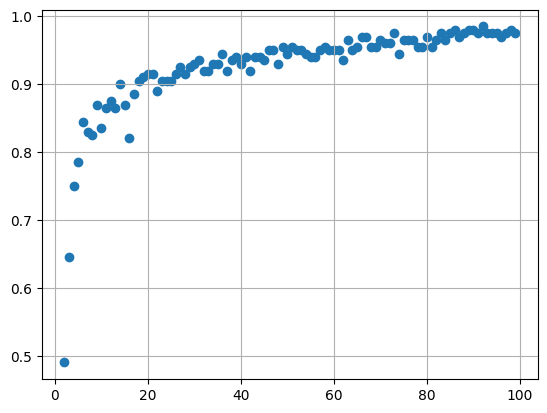

In [ ]:
plt.figure()
plt.scatter(df_res['neurons'], df_res['report.accuracy'])
plt.grid()
plt.show()
plt.close()

**Construção de grade de avaliação**

In [ ]:
steps = 100

grid_x0 = np.linspace(
    start=np.floor(np.min(data[:, 0])),
    stop=np.ceil(np.max(data[:, 0])),
    num=steps
)
grid_x1 = np.linspace(
    start=np.floor(np.min(data[:, 1])),
    stop=np.ceil(np.max(data[:, 1])),
    num=steps
)

grid = list()
for x0 in grid_x0:
    for x1 in grid_x1:
        grid.append([x0, x1])

grid = np.array(grid)
grid.shape

(10000, 2)

**Avaliação de modelo bem ajustado**

In [ ]:
model = ELMClassifier(neurons=15)
model.fit(data, target)
preds = model.predict(grid)

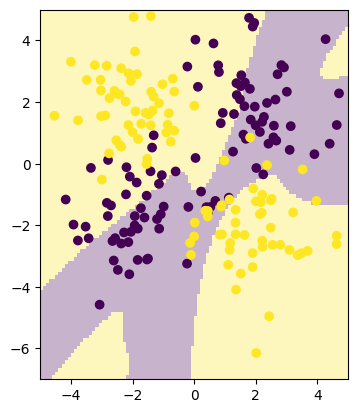

In [ ]:
plt.figure()
plt.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

**Avaliação de modelo sobre-ajustado**

In [ ]:
model = ELMClassifier(neurons=100)
model.fit(data, target)
preds = model.predict(grid)

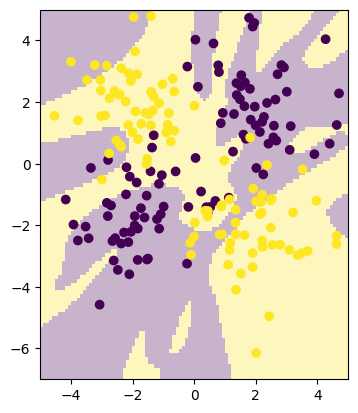

In [ ]:
plt.figure()
plt.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

\pagebreak

## Exercício ELM com Regularização

**Especificação de parâmetros**

In [ ]:
neurons_hidden = 256
neurons_output = 1

**Camada de Entrada:** geração de pesos aleatórios

In [ ]:
input_weights = np.random.uniform(size=(data.shape[1] + 1, neurons_hidden))
input_weights.shape

(3, 256)

**Camada Escondida:** transformação da entrada com função de ativação não linear

In [ ]:
hidden_input = (
    np.hstack([np.ones(shape=(data.shape[0], 1)), data])
    @ input_weights
)
hidden_input.shape

(200, 256)

In [ ]:
hidden_output = np.tanh(hidden_input)
hidden_output = np.hstack([np.ones(shape=(data.shape[0], 1)), hidden_output])
hidden_output.shape

(200, 257)

**Camada de Saída:** cálculo de pesos da camada de saída com adição de regularização

$$
w = (\textbf{H}^T\textbf{H} + \lambda \textbf{I}_p)^{-1} \textbf{H}^T \textbf{y}
$$

**Avaliação do Modelo:** com regularização nula

In [ ]:
reg = 0

aux = np.linalg.pinv(
    (hidden_output.T @ hidden_output)
    + (reg * np.identity(neurons_hidden + 1))
)
output_weights = aux @ hidden_output.T @ target
output_input = hidden_output @ output_weights
output_output = output_input * 1

print(classification_report(y_pred=output_output > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       100
        True       0.99      0.98      0.98       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



**Avaliação do Modelo:** com regularização não nula arbitrária

In [ ]:
reg = 0.1

aux = np.linalg.pinv(
    (hidden_output.T @ hidden_output)
    + (reg * np.identity(neurons_hidden + 1))
)
output_weights = aux @ hidden_output.T @ target
output_input = hidden_output @ output_weights
output_output = output_input * 1

print(classification_report(y_pred=output_output > 0, y_true=target > 0))

              precision    recall  f1-score   support

       False       0.93      0.94      0.94       100
        True       0.94      0.93      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



---

### Modelo Classificador ELM

In [ ]:
class ELMClassifier:
    def __init__(self, neurons: int, reg: float = 0.0):
        self.neurons = neurons
        self.reg = reg

    def fit(self, X, y):
        # GENERATE RANDOM HIDDEN LAYER WEIGHTS
        self.w_input_ = np.random.uniform(size=(X.shape[1] + 1, self.neurons))

        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])
        
        # CALCULATE OUTPUT LAYER WEIGHTS
        aux = np.linalg.pinv(
            (hidden_output.T @ hidden_output)
            + (self.reg * np.identity(self.neurons + 1))
        )
        self.w_output_ = aux @ hidden_output.T @ y

        return self

    def predict(self, X):
        # CALCULATE HIDDEN LAYER INPUT
        hidden_input = (
            np.hstack([np.ones(shape=(X.shape[0], 1)), X])
            @ self.w_input_
        )

        # CALCULATE HIDDEN LAYER OUTPUT
        hidden_output = np.tanh(hidden_input)
        hidden_output = np.hstack([
            np.ones(shape=(X.shape[0], 1)),
            hidden_output
        ])

        # CALCULATE OUTPUT LAYER INPUT VALUES
        output_input = hidden_output @ self.w_output_

        # OUTPUT LAYER ACTIVATEION FUNCTION IS LINEAR
        return output_input.reshape(-1, 1)

**Construção de grade de avaliação**

In [ ]:
steps = 100

grid_x0 = np.linspace(
    start=np.floor(np.min(data[:, 0])),
    stop=np.ceil(np.max(data[:, 0])),
    num=steps
)
grid_x1 = np.linspace(
    start=np.floor(np.min(data[:, 1])),
    stop=np.ceil(np.max(data[:, 1])),
    num=steps
)

grid = list()
for x0 in grid_x0:
    for x1 in grid_x1:
        grid.append([x0, x1])

grid = np.array(grid)
grid.shape

(10000, 2)

**Avaliação de modelo bem ajustado**

In [ ]:
model = ELMClassifier(neurons=15)
model.fit(data, target)
preds = model.predict(grid)

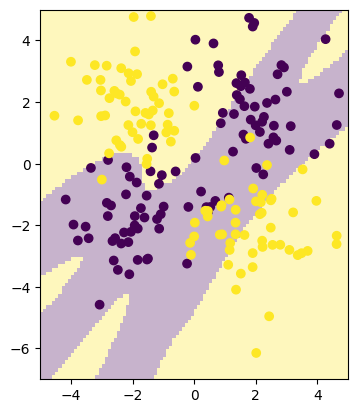

In [ ]:
plt.figure()
plt.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

**Avaliação de modelo sobre-ajustado**

In [ ]:
model = ELMClassifier(neurons=100)
model.fit(data, target)
preds = model.predict(grid)

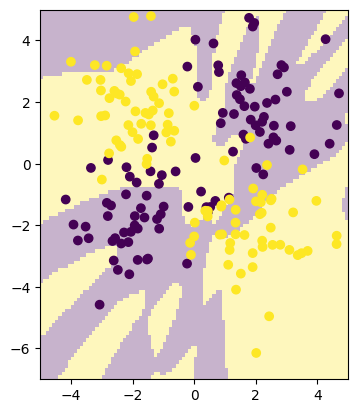

In [ ]:
plt.figure()
plt.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

**Avaliação de modelo sobre-ajustado com regularização**

In [ ]:
model = ELMClassifier(neurons=100, reg=1)
model.fit(data, target)
preds = model.predict(grid)

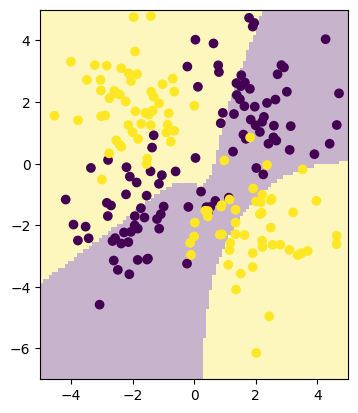

In [ ]:
plt.figure()
plt.imshow(
    (preds * -1 > 0).reshape(steps, steps),
    extent=(grid_x0[0], grid_x0[-1], grid_x1[0], grid_x1[-1]),
    alpha=.3
)
plt.scatter(data[:, 0], data[:, 1], c=target)
plt.show()
plt.close()

## Exercício ELM com Regularização em Dados Reais

* **Dataset selecionado:** [Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29) (January 8, 1991)

* **Descrição das colunas de características disponíveis:**

n  Attribute                     Domain
-- ----------------------------- -----------
1. Sample code number            id number
2. Clump Thickness               1 - 10
3. Uniformity of Cell Size       1 - 10
4. Uniformity of Cell Shape      1 - 10
5. Marginal Adhesion             1 - 10
6. Single Epithelial Cell Size   1 - 10
7. Bare Nuclei                   1 - 10
8. Bland Chromatin               1 - 10
9. Normal Nucleoli               1 - 10
10. Mitoses                      1 - 10
11. Class:                       (2 for benign, 4 for malignant)

* **Proporção das Classes:**

Classe     Proporção
--------- -----------
Benign    458 (65.5%)
Malignant 241 (34.5%)

In [ ]:
from io import StringIO

url = (
    'https://archive.ics.uci.edu/ml/'
    + 'machine-learning-databases/'
    + 'breast-cancer-wisconsin/'
    + 'breast-cancer-wisconsin.data'
)
response = requests.get(url)
df = pd.read_csv(StringIO(response.content.decode('utf-8')), header=None)

**Pre-processamento**

In [ ]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1:]
X.shape, y.shape

((699, 9), (699, 1))

In [ ]:
model = ELMClassifier(neurons=100, reg=1)
model.fit(X, y)
preds = model.predict(y)

TypeError: can't multiply sequence by non-int of type 'float'